# Investigate results of fitting procedure

In [1]:
import sys
sys.path.append("../python/")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import bokeh.palettes
import _corner
import imp
imp.reload(_corner)
from _corner import corner
from scipy.stats import gaussian_kde
import pickle
from matplotlib.offsetbox import AnchoredText
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM
from scipy.interpolate import griddata
import matplotlib.colors as colors

from matplotlib import rc
rc('font', family='times new roman', size=22.)

### Dependence of results with relative uncertainty 

Plot posterior

0.8452422416044016 1.052955241832966


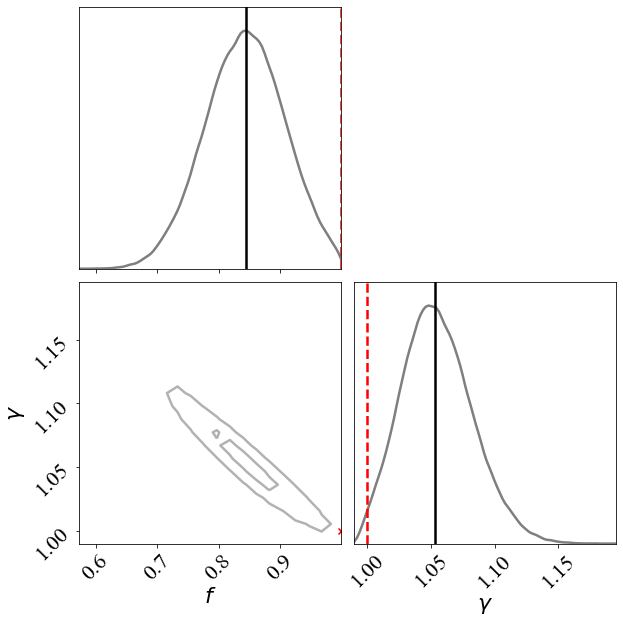

In [18]:
_file   = open("../results/bayesian/likelihood_game0_uncTobs_0.03v97", "rb") 
like    = pickle.load(_file)
_file   = open("../results/bayesian/posterior_game0_uncTobs_0.03v97", "rb") 
samples = pickle.load(_file)

smooth=0.5
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth)

# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 3], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5, alpha=0.5)

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0], ls="-", lw=2.5, color="k")
axes[1, 1].axvline(ML[1], ls="-", lw=2.5, color="k")
axes[0, 0].axvline(1., ls="--", lw=2.5, color="red")
axes[1, 1].axvline(1., ls="--", lw=2.5, color="red")
axes[1, 0].scatter(1., 1., marker="x", color="red")

axes[1, 0].set_ylabel(r"$\gamma$")
axes[1, 0].set_xlabel(r"$f$")
axes[1, 1].set_xlabel(r"$\gamma$")

print(ML[0], ML[1])

In [17]:
def FSE_f_gamma(filepath, f_true, gamma_true, rel_unc_Tobs=[0.01, 0.02, 0.03, 0.05, 0.10, 0.25, 0.50]):
    """
    Return Fractional Standard Error
    """
    mean = {}; median = {}; MAP = {}; ML = {};
    for rel_unc in rel_unc_Tobs:
        data = np.genfromtxt(filepath + ("statistics_game0_uncTobs_%.2f.dat" %rel_unc), unpack=True)
        mean[rel_unc]   = np.array((data[0], data[1]))
        #print(mean[rel_unc].shape, mean[rel_unc][:, 0], mean[rel_unc][0])
        median[rel_unc] = np.array((data[2], data[3]))
        MAP[rel_unc]    = np.array((data[4], data[5]))
        ML[rel_unc]     = np.array((data[6], data[7]))
        
    true          = [f_true, gamma_true]
    rank          = mean[rel_unc].shape[1]
    D             = mean[rel_unc].shape[0] # dimension parameter space
    FSE           = {}
    FSE["mean"]   = []
    FSE["median"] = []
    FSE["MAP"]    = []
    FSE["ML"]     = []
    
    for i in range(D):
        FSE["mean"].append([])
        FSE["median"].append([])
        FSE["MAP"].append([])
        FSE["ML"].append([])
        for rel_unc in rel_unc_Tobs:
            FSE["mean"][i].append(np.sqrt(1/rank*np.sum(np.power(mean[rel_unc][i] - true[i], 2)))/true[i])
            FSE["median"][i].append(np.sqrt(1/rank*np.sum(np.power(median[rel_unc][i] - true[i], 2)))/true[i])
            FSE["MAP"][i].append(np.sqrt(1/rank*np.sum(np.power(MAP[rel_unc][i] - true[i], 2)))/true[i])
            FSE["ML"][i].append(np.sqrt(1/rank*np.sum(np.power(ML[rel_unc][i] - true[i], 2)))/true[i])
    return FSE

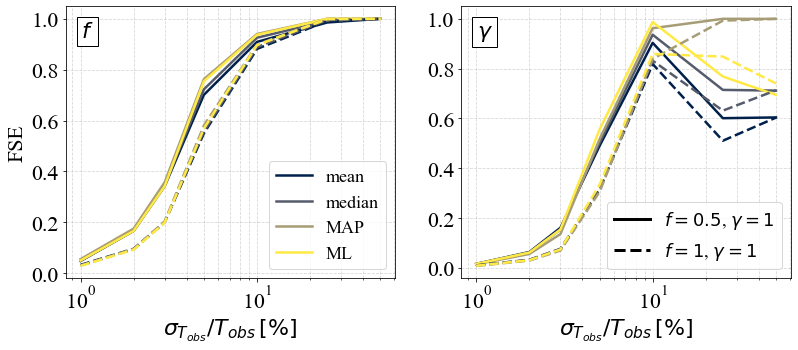

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

filepath     = "../results/bayesian/game0/"
labels       = ["mean", "median", "MAP", "ML"]
rel_unc_Tobs = [0.01, 0.02, 0.03, 0.05, 0.10, 0.25, 0.50]

gamma_true = 1
f_true     = [0.5, 1.]
folder     = ["f05gamma1/", "f1gamma1/"] # CAREFULL!!
ls         = ["-", "--"]
lines      = [Line2D([0], [0], color="k", linewidth=3, linestyle=l) for l in ls]
llabels    = ["$f=0.5$, $\gamma=1$", "$f=1$, $\gamma=1$"] # CAREFULL!!

nPE        = 4 # number point estimates
colors     = bokeh.palettes.cividis(nPE)
j          = -1

for i in range(len(f_true)):
    j += 1
    FSE = FSE_f_gamma(filepath + folder[i], f_true[i], gamma_true)
    for k in range(nPE):
        if j==0:
            ax[0].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][0], label=labels[k], lw=2.5, 
                       color=colors[k], ls=ls[j])
        else:
            ax[0].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][0], lw=2.5, color=colors[k], ls=ls[j])
        ax[1].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][1], lw=2.5, color=colors[k], ls=ls[j])

ax[0].legend(frameon=True, fontsize=18)
ax[1].legend(lines, llabels, frameon=True, fontsize=18)
ax[0].set_ylabel("FSE")
ax[0].set_xlabel(r"$\sigma_{T_{obs}}/T_{obs}\, [\%]$")
ax[1].set_xlabel(r"$\sigma_{T_{obs}}/T_{obs}\, [\%]$")

text_box = AnchoredText(r"$f$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[0].add_artist(text_box)
text_box = AnchoredText(r"$\gamma$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[1].add_artist(text_box)

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[1].grid(which="both", ls="--", alpha=0.5)

fig.savefig("../Figs/game0_FS1_nBDs10000.pdf", bbox_inches="tight")

**Understand why funny shape FSE for $\gamma$**

Text(0.5, 0, '$\\gamma$')

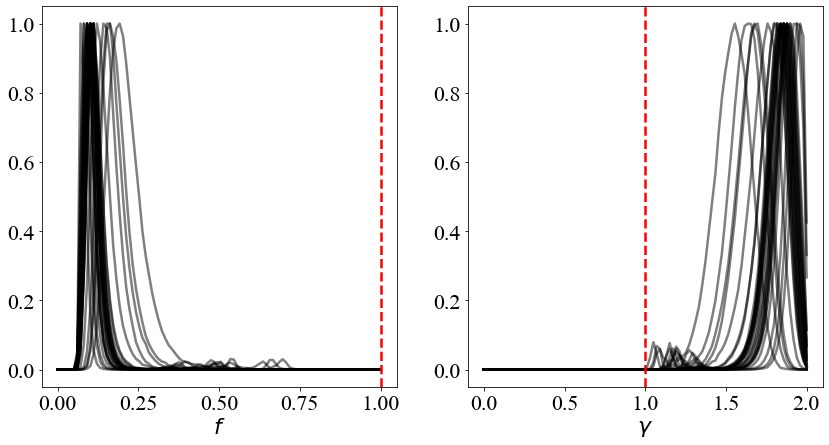

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

xvals0 = np.linspace(0, 1, 100)
xvals1 = np.linspace(0, 2, 100)
    
for i in range(30):
    _file   = open("../results/bayesian/posterior_game0_uncTobs_0.1v" + str(i), "rb") 
    samples = pickle.load(_file)
    kde   = gaussian_kde(samples.T[0])
    ax[0].plot(xvals0, kde(xvals0)/np.max(kde(xvals0)), color="k", lw=2.5, alpha=0.5)
    kde   = gaussian_kde(samples.T[1])
    ax[1].plot(xvals1, kde(xvals1)/np.max(kde(xvals1)), color="k", lw=2.5, alpha=0.5)

ax[0].axvline(1., ls="--", lw=2.5, color="red")
ax[1].axvline(1., ls="--", lw=2.5, color="red")

ax[0].set_xlabel(r"$f$")
ax[1].set_xlabel(r"$\gamma$")

Text(0.5, 0, '$\\gamma$')

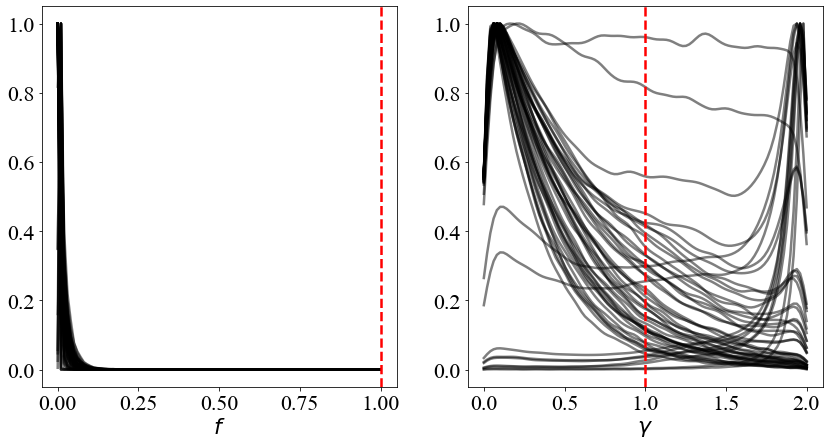

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

xvals0 = np.linspace(0, 1, 100)
xvals1 = np.linspace(0, 2, 100)
    
for i in range(50):
    _file   = open("../results/bayesian/posterior_game0_uncTobs_0.25v" + str(i), "rb") 
    samples = pickle.load(_file)
    kde   = gaussian_kde(samples.T[0])
    ax[0].plot(xvals0, kde(xvals0)/np.max(kde(xvals0)), color="k", lw=2.5, alpha=0.5)
    kde   = gaussian_kde(samples.T[1])
    ax[1].plot(xvals1, kde(xvals1)/np.max(kde(xvals1)), color="k", lw=2.5, alpha=0.5)

ax[0].axvline(1., ls="--", lw=2.5, color="red")
ax[1].axvline(1., ls="--", lw=2.5, color="red")

ax[0].set_xlabel(r"$f$")
ax[1].set_xlabel(r"$\gamma$")

Text(0.5, 0, '$\\gamma$')

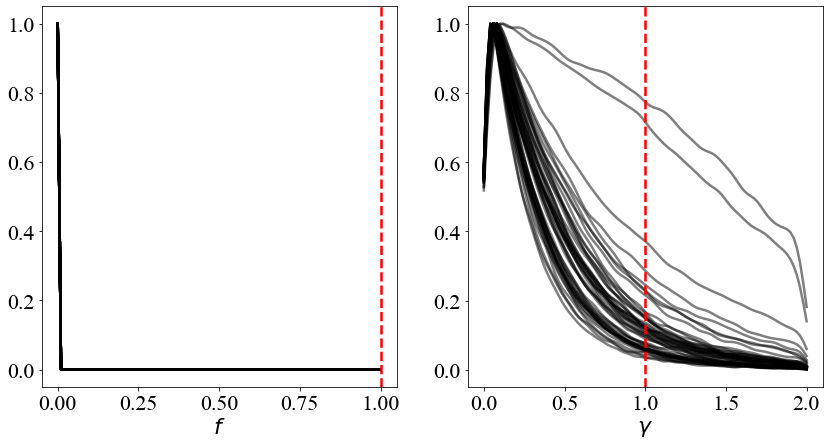

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

xvals0 = np.linspace(0, 1, 100)
xvals1 = np.linspace(0, 2, 100)
    
for i in range(50):
    _file   = open("../results/bayesian/posterior_game0_uncTobs_0.5v" + str(i), "rb") 
    samples = pickle.load(_file)
    kde   = gaussian_kde(samples.T[0])
    ax[0].plot(xvals0, kde(xvals0)/np.max(kde(xvals0)), color="k", lw=2.5, alpha=0.5)
    kde   = gaussian_kde(samples.T[1])
    ax[1].plot(xvals1, kde(xvals1)/np.max(kde(xvals1)), color="k", lw=2.5, alpha=0.5)

ax[0].axvline(1., ls="--", lw=2.5, color="red")
ax[1].axvline(1., ls="--", lw=2.5, color="red")

ax[0].set_xlabel(r"$f$")
ax[1].set_xlabel(r"$\gamma$")

### Dependence of results with observed number of BDs

In [36]:
def FSE_f_gamma(filepath, f_true, gamma_true, nBDs=[1000, 5000, 10000, 20000, 50000, 100000]):
    """
    Return Fractional Standard Error
    """
    mean = {}; median = {}; MAP = {}; ML = {};
    for n in nBDs:
        if n==10000:
            data = np.genfromtxt(filepath + "statistics_game0_uncTobs_0.05.dat", unpack=True)
        else:
            data = np.genfromtxt(filepath + ("statistics_game0_nBDs_%i.dat" %n), unpack=True)
        mean[n]   = np.array((data[0], data[1]))
        median[n] = np.array((data[2], data[3]))
        MAP[n]    = np.array((data[4], data[5]))
        ML[n]     = np.array((data[6], data[7]))
        
    true          = [f_true, gamma_true]
    rank          = mean[n].shape[1]
    D             = mean[n].shape[0] # dimension parameter space
    FSE           = {}
    FSE["mean"]   = []
    FSE["median"] = []
    FSE["MAP"]    = []
    FSE["ML"]     = []
    
    for i in range(D):
        FSE["mean"].append([])
        FSE["median"].append([])
        FSE["MAP"].append([])
        FSE["ML"].append([])
        for n in nBDs:
            FSE["mean"][i].append(np.sqrt(1/rank*np.sum(np.power(mean[n][i] - true[i], 2)))/true[i])
            FSE["median"][i].append(np.sqrt(1/rank*np.sum(np.power(median[n][i] - true[i], 2)))/true[i])
            FSE["MAP"][i].append(np.sqrt(1/rank*np.sum(np.power(MAP[n][i] - true[i], 2)))/true[i])
            FSE["ML"][i].append(np.sqrt(1/rank*np.sum(np.power(ML[n][i] - true[i], 2)))/true[i])
    return FSE

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

filepath     = "../results/bayesian/game0/"
labels       = ["mean", "median", "MAP", "ML"]
rel_unc_Tobs = [0.01, 0.02, 0.03, 0.05, 0.10, 0.25, 0.50]

gamma_true = 1
f_true     = [0.5, 1.]
folder     = ["f05gamma1/", "f1gamma1/"] # CAREFULL!!
ls         = ["-", "--"]
lines      = [Line2D([0], [0], color="k", linewidth=3, linestyle=l) for l in ls]
llabels    = ["$f=0.5$, $\gamma=1$", "$f=1$, $\gamma=1$"] # CAREFULL!!

nPE        = 4 # number point estimates
colors     = bokeh.palettes.cividis(nPE)
j          = -1

for i in range(len(f_true)):
    j += 1
    FSE = FSE_f_gamma(filepath + folder[i], f_true[i], gamma_true)
    for k in range(nPE):
        if j==0:
            ax[0].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][0], label=labels[k], lw=2.5, 
                       color=colors[k], ls=ls[j])
        else:
            ax[0].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][0], lw=2.5, color=colors[k], ls=ls[j])
        ax[1].plot(np.array(rel_unc_Tobs)*100, FSE[labels[k]][1], lw=2.5, color=colors[k], ls=ls[j])

ax[0].legend(frameon=True, fontsize=18)
ax[1].legend(lines, llabels, frameon=True, fontsize=18)
ax[0].set_ylabel("FSE")
ax[0].set_xlabel(r"$\sigma_{T_{obs}}/T_{obs}\, [\%]$")
ax[1].set_xlabel(r"$\sigma_{T_{obs}}/T_{obs}\, [\%]$")

text_box = AnchoredText(r"$f$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[0].add_artist(text_box)
text_box = AnchoredText(r"$\gamma$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[1].add_artist(text_box)

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[1].grid(which="both", ls="--", alpha=0.5)

fig.savefig("../Figs/game0_FS1_nBDs10000.pdf", bbox_inches="tight")

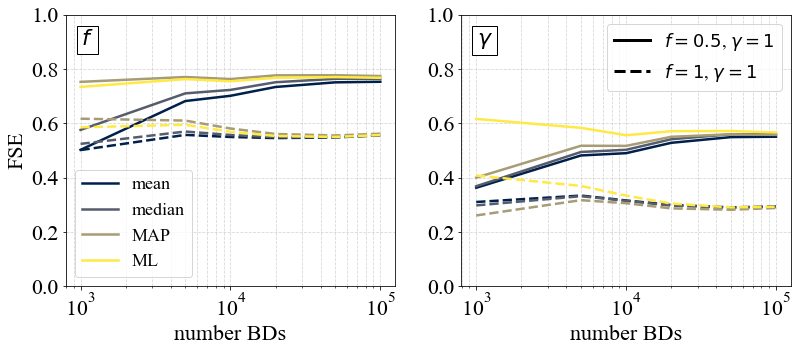

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

filepath     = "../results/bayesian/game0/"
labels       = ["mean", "median", "MAP", "ML"]
nBDs         = [1000, 5000, 10000, 20000, 50000, 100000]

gamma_true = 1
f_true     = [0.5, 1.]
folder     = ["f05gamma1/", "f1gamma1/"] # CAREFULL!!
ls         = ["-", "--"]
lines      = [Line2D([0], [0], color="k", linewidth=3, linestyle=l) for l in ls]
llabels    = ["$f=0.5$, $\gamma=1$", "$f=1$, $\gamma=1$"] # CAREFULL!!

nPE        = 4 # number point estimates
colors     = bokeh.palettes.cividis(nPE)
j          = -1

for i in range(len(f_true)):
    j += 1
    FSE = FSE_f_gamma(filepath + folder[i], f_true[i], gamma_true)
    for k in range(nPE):
        if j==0:
            ax[0].plot(nBDs, FSE[labels[k]][0], label=labels[k], lw=2.5, color=colors[k], ls=ls[j])
        else:
            ax[0].plot(nBDs, FSE[labels[k]][0], lw=2.5, color=colors[k], ls=ls[j])
        ax[1].plot(nBDs, FSE[labels[k]][1], lw=2.5, color=colors[k], ls=ls[j])

ax[0].legend(frameon=True, fontsize=18)
ax[1].legend(lines, llabels, frameon=True, fontsize=18)
ax[0].set_ylabel("FSE")
ax[0].set_xlabel("number BDs")
ax[1].set_xlabel("number BDs")

text_box = AnchoredText(r"$f$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[0].add_artist(text_box)
text_box = AnchoredText(r"$\gamma$", frameon=True, loc=2, pad=0.2)
plt.setp(text_box.patch, facecolor="white")
ax[1].add_artist(text_box)

ax[0].set_ylim([0, 1])
ax[1].set_ylim([0, 1])

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[1].grid(which="both", ls="--", alpha=0.5)

fig.savefig("../Figs/game0_FS1_uncTobs0.05.pdf", bbox_inches="tight")

### Generalization

In [72]:
def FSE_grid_f_gamma(filepath, nBDs, rel_unc, 
                     rank=100, D=2, PE="median", ax=False, plot_f=True):
    """
    Plot FSE in (f, gamma) plane
    """
    # grid points
    f     = np.array([0.1, 0.3, 0.5, 0.7])#, 0.9])
    gamma = np.array([0.2, 0.6, 1, 1.4, 1.8])
    
    FSE_1 = []; FSE_2 = [] 
    for _f in f:
        for _g in gamma:
            true = [_f, _g]
            data = np.genfromtxt(filepath + ("N%i_relunc%.2f/statistics_ex1_N%i_relunc%.2f_f%.1fgamma%.1f" 
                                             %(nBDs, rel_unc, nBDs, rel_unc, _f, _g)), unpack=True)
            if PE=="median":
                pe = np.array((data[2], data[3]))
            else:
                sys.exit("Need to implement other point estimates")

            FSE_1.append(np.sqrt(1/rank*np.sum(np.power(pe[0] - true[0], 2)))/true[0])
            FSE_2.append(np.sqrt(1/rank*np.sum(np.power(pe[1] - true[1], 2)))/true[1])
            #print(_f, _g, np.sqrt(1/rank*np.sum(np.power(pe[0] - true[0], 2)))/true[0])
            #print(pe[0], true[0])
    
    xi, yi = np.mgrid[0:1:(len(f)+1)*1j, 0:2:(len(gamma)+1)*1j]
    zi_1   = np.array(FSE_1).reshape(len(f), len(gamma))
    zi_2   = np.array(FSE_2).reshape(len(f), len(gamma))
    
    norm = colors.BoundaryNorm(boundaries=np.arange(0, 1, 0.05), ncolors=256)
    
    if ax == False:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        if plot_f==True:
            im = ax.pcolormesh(xi, yi, zi_1, norm=norm, cmap="magma_r")
        else:
            im = ax.pcolormesh(xi, yi, zi_2, norm=norm, cmap="viridis_r")
        cbar = fig.colorbar(im)
        cbar.ax.set_title("FSE", size=18.)
    else:
        if plot_f==True:
            im = ax.pcolormesh(xi, yi, zi_1, norm=norm, cmap="magma_r")
        else:
            im = ax.pcolormesh(xi, yi, zi_2, cmap="viridis_r")
    ax.set_ylabel(r"$\gamma$"); ax.set_xlabel(r"$f$")
    return

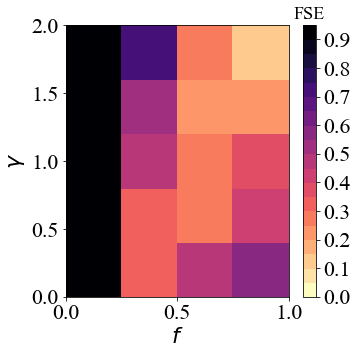

In [7]:
filepath = "../results/bayesian/ex1/N100_relunc0.05/"
nBDs     = 100
rel_unc  = 0.05
FSE_grid_f_gamma(filepath, nBDs, rel_unc)

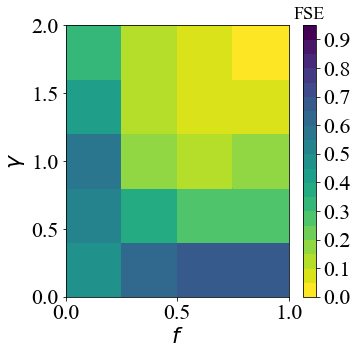

In [95]:
FSE_grid_f_gamma(filepath, nBDs, rel_unc, plot_f=False)

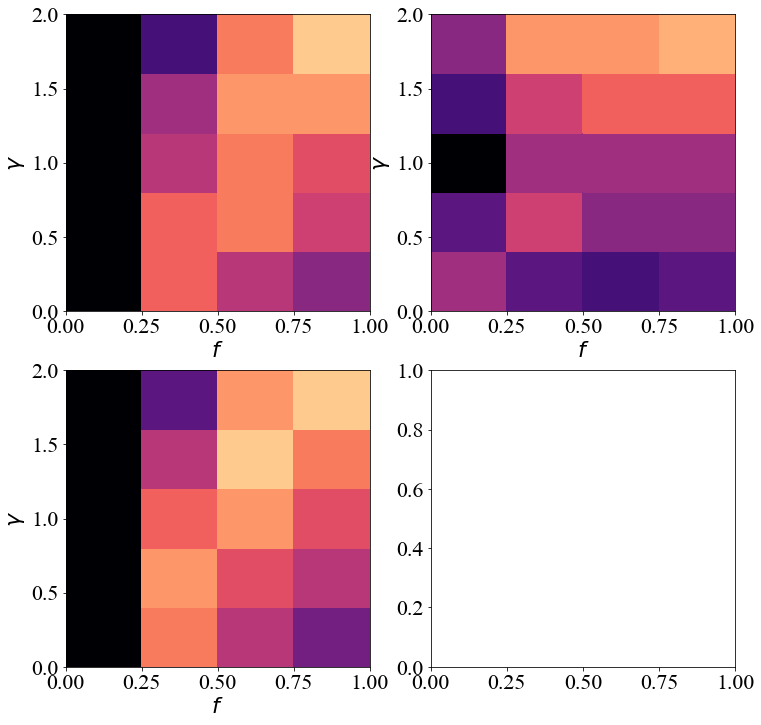

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

filepath = "../results/bayesian/ex1/"
nBDs     = 100 ; rel_unc  = 0.05
FSE_grid_f_gamma(filepath, nBDs, rel_unc, ax=ax[0, 0])
nBDs     = 100 ; rel_unc  = 0.10
FSE_grid_f_gamma(filepath, nBDs, rel_unc, ax=ax[1, 0])

nBDs     = 1000 ; rel_unc  = 0.05
FSE_grid_f_gamma(filepath, nBDs, rel_unc, ax=ax[0, 1])

In [112]:
def FSE_f_gamma(filepath, nBDs, rel_unc, rank=100, D=2, PE="median"):
    # grid points
    f     = np.array([0.1, 0.3, 0.5, 0.7])#, 0.9])
    gamma = np.array([0.2, 0.6, 1, 1.4, 1.8])
    
    FSE_1 = []; FSE_2 = [] 
    for _f in f:
        for _g in gamma:
            true = [_f, _g]
            data = np.genfromtxt(filepath + ("N%i_relunc%.2f/statistics_ex1_N%i_relunc%.2f_f%.1fgamma%.1f" 
                                             %(nBDs, rel_unc, nBDs, rel_unc, _f, _g)), unpack=True)
            if PE=="median":
                pe = np.array((data[2], data[3]))
            else:
                sys.exit("Need to implement other point estimates")

            FSE_1.append(np.sqrt(1/rank*np.sum(np.power(pe[0] - true[0], 2)))/true[0])
            FSE_2.append(np.sqrt(1/rank*np.sum(np.power(pe[1] - true[1], 2)))/true[1])
            #print(_f, _g, np.sqrt(1/rank*np.sum(np.power(pe[0] - true[0], 2)))/true[0])
            #print(pe[0], true[0])
    
    xi, yi = np.mgrid[0:1:(len(f)+1)*1j, 0:2:(len(gamma)+1)*1j]
    zi_1   = np.array(FSE_1).reshape(len(f), len(gamma))
    zi_2   = np.array(FSE_2).reshape(len(f), len(gamma))
    
    return xi, yi, zi_1, zi_2


def plot_FSE_grid_f_gamma(filepath, fig, axes, rank=100, D=2, PE="median", plot_f=True):
    """
    Plot FSE in (f, gamma) plane
    """
    norm = colors.BoundaryNorm(boundaries=np.arange(0, 1, 0.05), ncolors=256)
    
    nBDs = [100, 1000]
    rel_unc = [0.05, 0.1]
    
    j=0; k=0;
        
    for i, ax in enumerate(axes.flat):
        
        if i==3: 
            ax.remove()
            continue
        
        #print(i, j, k)
        xi, yi, zi_1, zi_2 = FSE_f_gamma(filepath, nBDs[j], rel_unc[k], rank=rank, D=D, PE=PE)
        
        if plot_f==True:
            im = ax.pcolormesh(xi, yi, zi_1, norm=norm, cmap="magma_r")
        else:
            im = ax.pcolormesh(xi, yi, zi_2, norm=norm, cmap="viridis_r")
        
        ax.set_ylabel(r"$\gamma$"); ax.set_xlabel(r"$f$")
        
        text_box = AnchoredText(("N=%i, unc T=%i" %(nBDs[j], int(rel_unc[k]*100))) + "$\%$", frameon=True, loc=2, pad=0.2)
        plt.setp(text_box.patch, facecolor="white")
        ax.add_artist(text_box)
        
        if i==0 or i==2: 
            k=1;
        if i==1:
            k=0; j=1; 
            
            
    fig.subplots_adjust(right=0.87)
    cbar_ax = fig.add_axes([0.91, 0.25, 0.02, 0.4])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.set_title("FSE", size=18.)
               
    return

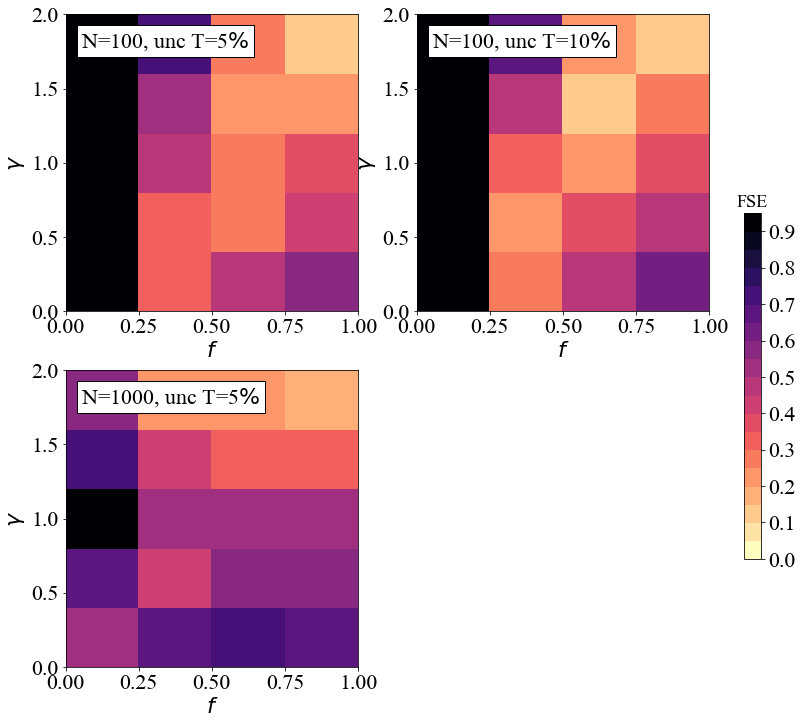

In [113]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

filepath = "../results/bayesian/ex1/"
plot_FSE_grid_f_gamma(filepath, fig, ax)

fig.savefig("../Figs/ex1_FSE_f.pdf")

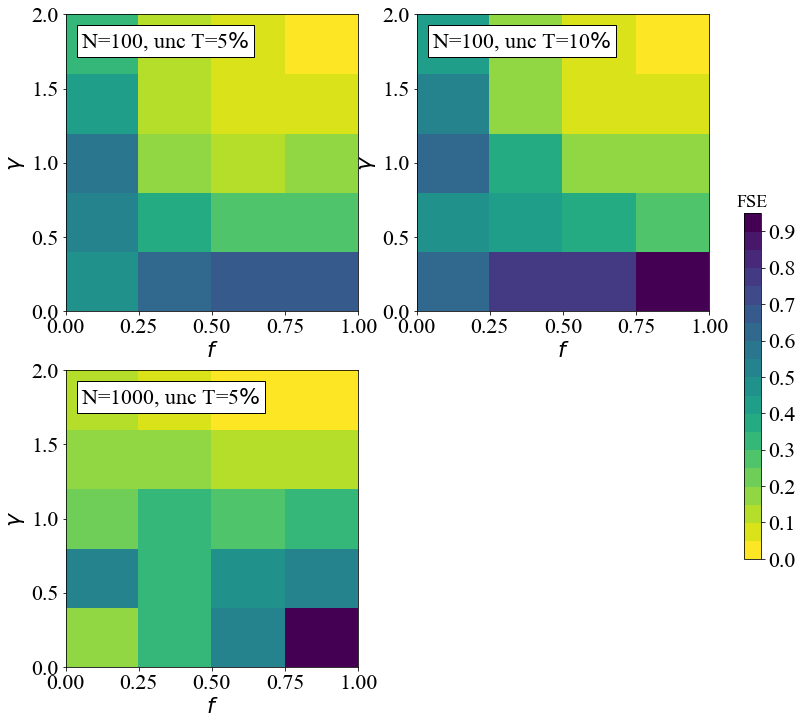

In [114]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

filepath = "../results/bayesian/ex1/"
plot_FSE_grid_f_gamma(filepath, fig, ax, plot_f=False)

fig.savefig("../Figs/ex1_FSE_gamma.pdf")